In [1]:
import os
import tellurium as te
import numpy as np
import pandas as pd
import pickle

os.chdir('..')

In [2]:
with open('results/240707_VNMetGly_Keq_PSOs/train_myprob_3.obj', 'rb') as file:
    myprob = pickle.load(file)

In [3]:
with open('results/240707_VNMetGly_Keq_PSOs/checkpoint_t3.dat', 'rb') as file:
    pops = pickle.load(file)

In [4]:
from roadrunner import Config, RoadRunner, Logger
Logger.disableLogging()
Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, True)
Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)
Config.setValue(Config.LLVM_SYMBOL_CACHE, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_GVN, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_CFG_SIMPLIFICATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_COMBINING, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_INST_ELIMINATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_CODE_ELIMINATION, True)
Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_SIMPLIFIER, True)
Config.setValue(Config.SIMULATEOPTIONS_COPY_RESULT, True)
r = te.loadSBMLModel('/workspaces/ECFERS/models/240621_VN_Metabolism_Gly_Keq.sbml')
r.integrator.absolute_tolerance = 1e-8
r.integrator.relative_tolerance = 1e-8
r.integrator.maximum_num_steps = 2000
myprob.r =[r]

In [22]:
with open('/workspaces/ECFERS/src/frenda_brenda/Files/Reduced Complexity/240621_VN_Metabolism_Gly_Keq.txt', 'r') as f:
    antimony = f.read()

x = [*list(myprob._unscale(pops[0].champion_x))[:-1], myprob.variables[0]['empty']['dilution_factor']]
for p,v in zip(myprob.parameter_labels[:-1]+['dilution_factor'], x):
    start = antimony.find(p+' =')
    end = start + antimony[start:start+50].find(';')
    antimony = antimony.replace(antimony[start:end], p+' ='+str(v))

with open('/workspaces/ECFERS/results/240707_VNMetGly_Keq_PSOs/240621_VN_Metabolism_Gly_Keq_fitted.sbml', 'w') as f:
    f.write(te.loada(antimony).getSBML())

In [24]:
res = myprob._simulate(myprob._unscale(pops[0].champion_x))

In [26]:
np.where([k == 'C00022' for k in r.getFloatingSpeciesIds()])

(array([118]),)

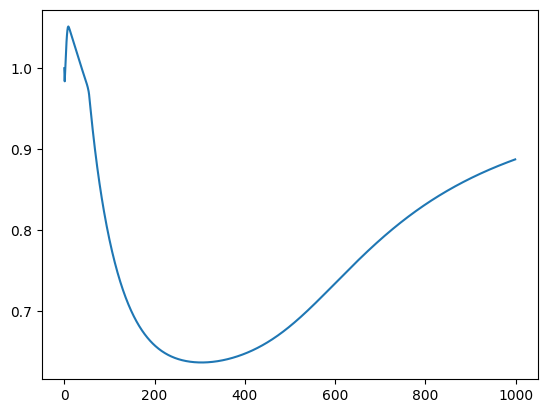

In [27]:
import matplotlib.pyplot as plt

plt.plot(res[0]['pyr'][:,118])

In [29]:
with open('results/240707_VNMetGly_BIOSYN_train-test/train_myprob_test.obj', 'rb') as file:
    myprob = pickle.load(file)

r = te.loadSBMLModel(myprob.model[0])
# make upper and lower bounds
upper = np.array([r[i]*100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [r[i]*100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [r[i]*100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [100 for _ in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [100, 100])

lower = np.array([r[i]/100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [r[i]/100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [r[i]/100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [1/100, 1/100])

from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
myprob = SBMLGlobalFit_Multi_Fly(
    model = myprob.model, 
    data = myprob.data, 
    parameter_labels=myprob.parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=myprob.metadata,
    variables=myprob.variables,
    scale=True,
    dlambda = 1)

In [30]:
with open('results/240707_VNMetGly_BIOSYN_train-test/checkpoint_t_test.dat', 'rb') as file:
    pops = pickle.load(file)

new_p_initial = np.array(myprob._unscale(pops[0].champion_x))
new_p_dict = {l:v for l,v in zip(myprob.parameter_labels,new_p_initial)}
new_upper = np.array([new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [new_p_dict['rel0']*10, new_p_dict['rel1']*10])

new_lower = np.array([new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [new_p_dict['rel0']/10, new_p_dict['rel1']/10])

myprob.set_bounds(new_upper, new_lower)
with open('results/240707_VNMetGly_BIOSYN_train-test/checkpoint_t_test2.dat', 'rb') as file:
    pops = pickle.load(file)

new_p_initial = np.array(myprob._unscale(pops[0].champion_x))
new_p_dict = {l:v for l,v in zip(myprob.parameter_labels,new_p_initial)}
new_upper = np.array([new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [new_p_dict[i]*100 for i in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [new_p_dict['rel0']*10, new_p_dict['rel1']*10])

new_lower = np.array([new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Kcat' in p]] + 
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Km' in p]] + 
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'Ki' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gnc' in p]] +
                 [1/100 for _ in [p for p in myprob.parameter_labels if 'Gc' in p]] +
                 [new_p_dict[i]/100 for i in [p for p in myprob.parameter_labels if 'v' in p]] + 
                 [new_p_dict['rel0']/10, new_p_dict['rel1']/10])

myprob.set_bounds(new_upper, new_lower)
with open('results/240707_VNMetGly_BIOSYN_train-test/checkpoint_t_testw.dat', 'rb') as file:
    pops = pickle.load(file)

In [33]:
with open('src/frenda_brenda/Files/Reduced Complexity/240621_VN_Metabolism_Gly_BIOSYN.txt', 'r') as f:
    antimony = f.read()

x = [*list(myprob._unscale(pops[0].champion_x)), myprob.variables[0]['empty']['dilution_factor']]
for p,v in zip(myprob.parameter_labels+['dilution_factor'], x):
    start = antimony.find(p+' =')
    end = start + antimony[start:start+50].find(';')
    antimony = antimony.replace(antimony[start:end], p+' ='+str(v))

with open('results/240707_VNMetGly_BIOSYN_train-test/240621_VN_Metabolism_Gly_BIOSYN_fitted.sbml', 'w') as f:
    f.write(te.loada(antimony).getSBML())